##ECSE 415 - Assignment 1: Image Filtering and Edge Detection

#Theo Ghanem 260972584

# 3 Image Stitching

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import cv2
from cv2 import NORM_L2

path = '/Users/theog/Documents/CodingProjects/ECSE415_Computer_Vision/Assignments/A2/A2-W24-images/Data/'

#Load the 2 images
image_1 = cv2.imread(path+'Q3/part1.png')
image_2 = cv2.imread(path+'Q3/part2.png')
image_3 = cv2.imread(path+'Q3/part3.png')

image_1 = cv2.cvtColor(image_1,cv2.COLOR_BGR2RGB)
image_2 = cv2.cvtColor(image_2,cv2.COLOR_BGR2RGB)
image_3 = cv2.cvtColor(image_3,cv2.COLOR_BGR2RGB)

# display images
plt.figure(figsize=(20, 20))
plt.subplot(131), plt.imshow(image_1)
plt.title('Image 1'), plt.xticks([]), plt.yticks([])
plt.subplot(132), plt.imshow(image_2)
plt.title('Image 2'), plt.xticks([]), plt.yticks([])
plt.subplot(133), plt.imshow(image_3)
plt.title('Image 3'), plt.xticks([]), plt.yticks([])
plt.show()



Helper method to crop out the black region out of images

In [2]:
def crop_black_portion(image):
  # Convert the image to grayscale
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

  # Threshold the image to create a binary image
  _, binary = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)

  # Find the first non-black pixel from left to right
  for i in range(binary.shape[1]):
    if np.any(binary[:, i] != 0):
      break

  # Crop the image from the first non-black pixel
  cropped_image = image[:, i:]

  return cropped_image

### (a) Compute the SIFT keypoints and corresponding descriptors for images 1 and 2.


In [3]:
# compute SIFT keypoints for both images
sift = cv2.SIFT_create()
keypoint_1, descriptor_1 = sift.detectAndCompute(image_1,None)
keypoint_2, descriptor_2 = sift.detectAndCompute(image_2,None)

### (b) Find matching keypoints in images 1 and 2 and display the 20 best pairs.

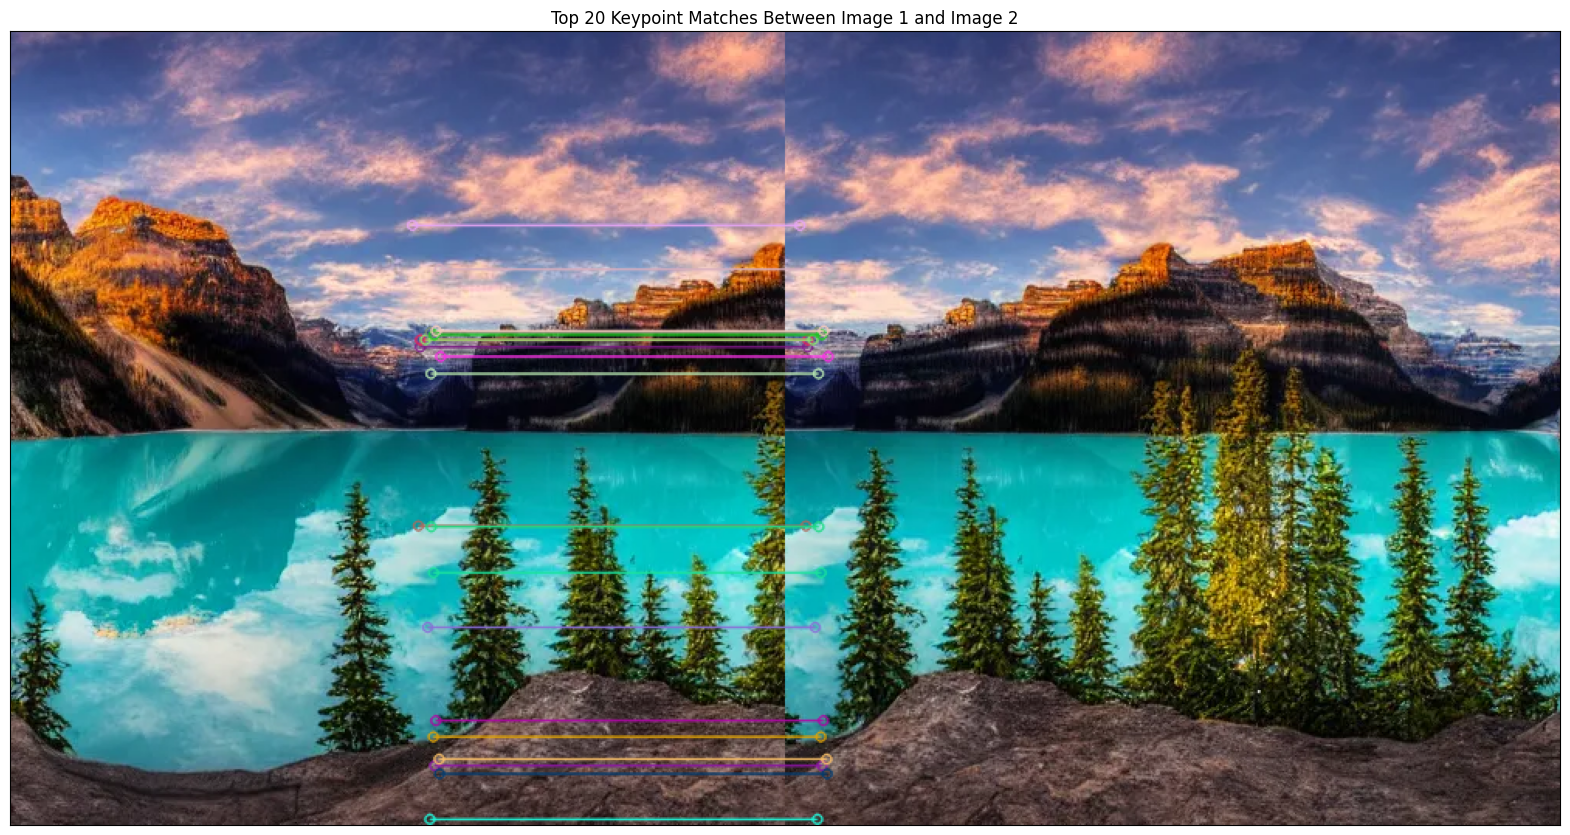

In [4]:
# match all keypoints between both images using a brute force matcher
bf = cv2.BFMatcher.create(normType = NORM_L2, crossCheck = True)
matches_image_12 = bf.match(descriptor_1,descriptor_2)

# sort matches by distance
matches_image_12 = sorted(matches_image_12, key = lambda x:x.distance)

# display best 20 matches
image_1_and_image_2 = cv2.drawMatches(image_1,keypoint_1,image_2,keypoint_2,matches_image_12[:20],None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(20, 20))
plt.imshow(image_1_and_image_2)
plt.title('Top 20 Keypoint Matches Between Image 1 and Image 2'), plt.xticks([]), plt.yticks([])
plt.show()

### (c) Find the homography that best matches the keypoints from image 1 and 2 using the RANSAC method, and apply the resulting transformation to image 1. Image 2 should not be transformed.

In [5]:
#Find the homography that best matches the keypoints from image 1 and 2 using the RANSAC method, and apply the resulting transformation to image 1. Image 2 should not be transformed.

# get the keypoints from the matches (from tutorial 4)
dst_pts = np.float32([ keypoint_1[m.queryIdx].pt for m in matches_image_12 ]).reshape(-1,1,2)
src_pts = np.float32([ keypoint_2[m.trainIdx].pt for m in matches_image_12 ]).reshape(-1,1,2)

# find the homography (from tutorial 4)
homography_12, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,4.0)

# warp image 1 to image 2 using the homography matrix
image_12 = cv2.warpPerspective(image_1, homography_12, (image_1.shape[1] + image_2.shape[1], image_1.shape[0]))


### (d) Stitch the transformed image 1 and the original image 2 together using linear image blending. Let us call this image 12. Display this image.

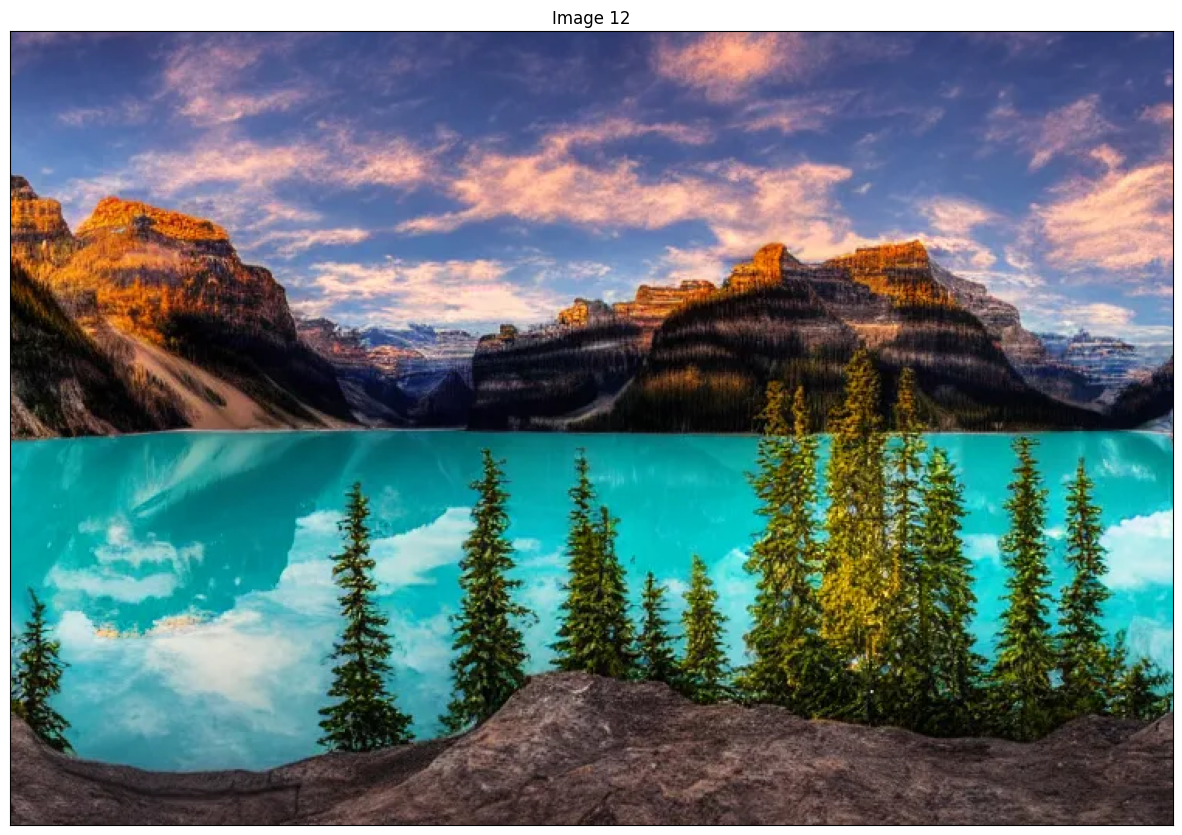

In [6]:
# merge image 2 to image 12 with linear blending
image_12[0:image_2.shape[0], image_2.shape[1]:image_2.shape[1]*2] = image_2

# display image 12
plt.figure(figsize=(15, 15))
plt.imshow(crop_black_portion(image_12))
plt.title('Image 12'), plt.xticks([]), plt.yticks([])
plt.show()

### (e) Compute the SIFT keypoints and corresponding descriptors for images 12 and 3.

In [7]:
# compute SIFT keypoints for image 12
keypoints_image_12, descriptor_image_12 = sift.detectAndCompute(image_12,None)
keypoints_image_3, descriptor_image_3 = sift.detectAndCompute(image_3,None)

### (f) Find the matching keypoints in 12 and 3 images and display the 20 best pairs.

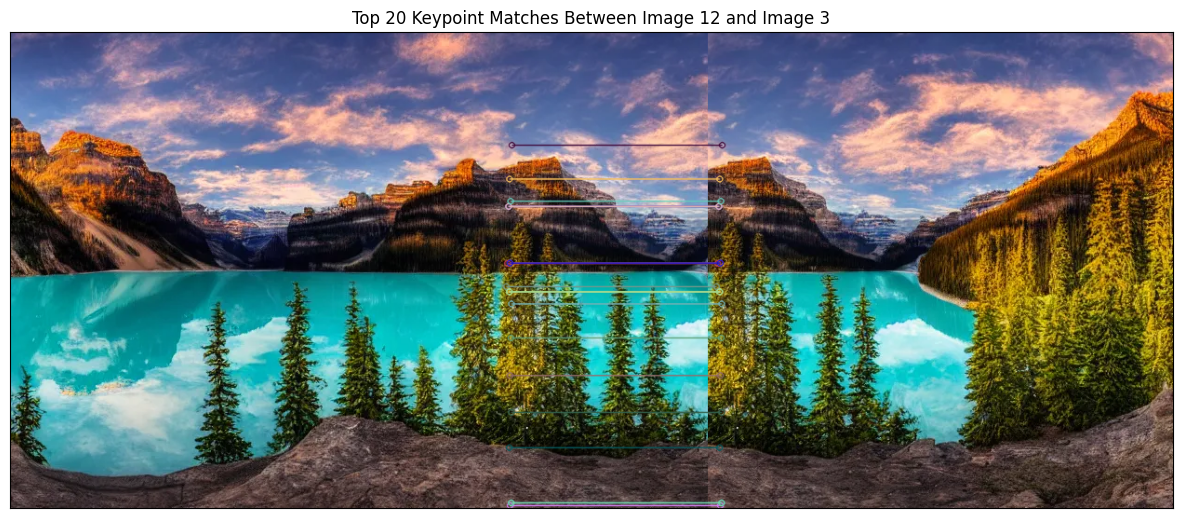

In [8]:
# match all keypoints between image 12 and image 3 using a brute force matcher
matches_image_123 = bf.match(descriptor_image_12,descriptor_image_3)

# sort matches by distance
matches_image_123 = sorted(matches_image_123, key = lambda x:x.distance)

# display best 20 matches
image_12_image_3 = cv2.drawMatches(image_12,keypoints_image_12,image_3,keypoints_image_3,matches_image_123[:20],None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(15, 15))
plt.imshow(crop_black_portion(image_12_image_3))
plt.title('Top 20 Keypoint Matches Between Image 12 and Image 3'), plt.xticks([]), plt.yticks([])
plt.show()


### (g) Compute the homography using the RANSAC method. Apply the transformation to image 3. Image 12 should not be transformed.


In [17]:

# compute homography matrix using RANSAC with the first 20 matches
dst_pts_123 = np.float32([ keypoints_image_12[m.queryIdx].pt for m in matches_image_123 ]).reshape(-1,1,2)
src_pts_123 = np.float32([ keypoints_image_3[m.trainIdx].pt for m in matches_image_123 ]).reshape(-1,1,2)

homography_matrix_123, _ = cv2.findHomography(src_pts_123, dst_pts_123, cv2.RANSAC, 5.0)

# warp image 12 to image 3 using the homography matrix
image_123 = cv2.warpPerspective(image_3, homography_matrix_123, (image_3.shape[1] + image_12.shape[1],image_3.shape[0]))
# wimg = cv2.warpPerspective(imgr, H, (imgr.shape[1]+imgl.shape[1],imgr.shape[0]))

### (h) Stitch the transformed image 3 and image 12 together using linear image blending. Display the resulting image.


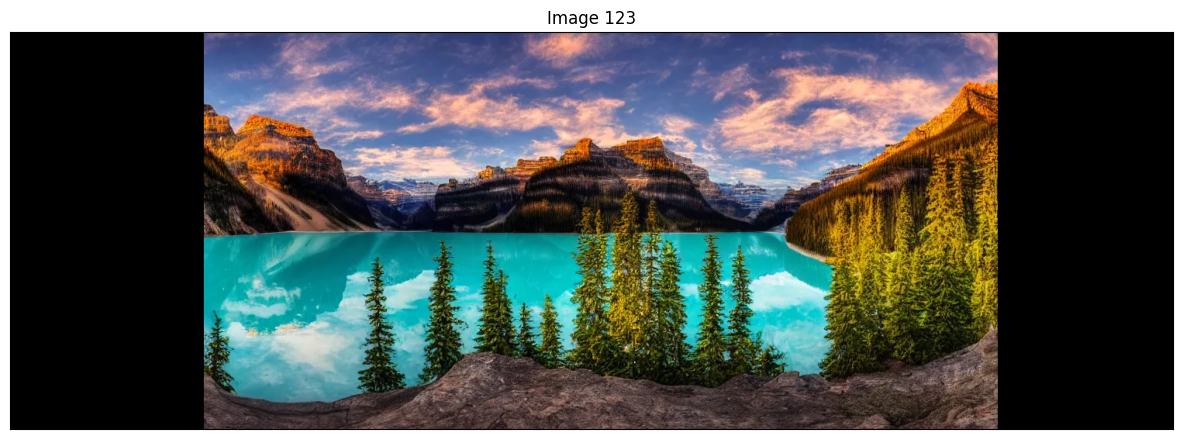

In [18]:
image_123[:, :image_12.shape[1], :] = image_12

# display final panoramic image
plt.figure(figsize=(15, 15))
plt.imshow(image_123)
plt.title('Image 123'), plt.xticks([]), plt.yticks([])
plt.show()

### (i) Discuss: Note that we could also use multi-band blending in the section 

 Multi-band blending is a technique used to blend two images together. It uses Gaussian pyramids to blend the images, which allows for a more seamless transition between the images. The Gaussian pyramids are created by applying a Gaussian filter to the images and then downsampling the images. The blending is done by combining the images at different levels of the Gaussian pyramid, which allows for a smooth transition between the images. It is more used when the images have a significant difference in brightness or contrast.t


### (h) When should one prefer pyramid blending over linear blending? 

One would prefer using pyramid blending over linear blending when they are looking for a sharper and better blend as the pyramid blending uses more intricate and precise blending whereas linear blending is a more simple and straightforward method.